In [1]:
import sys
sys.path.append('/tmp/pycharm_project_688')
sys.path.append('/tmp/pycharm_project_688/src')

Load up experiment & annotations

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction
from preprocessing._segmentation import segment_null_classification

%load_ext autoreload
%autoreload 2

from classification.classification import classify_all
from data_reading.phyphox import read_experiment, read_experiments_in_dir
from features import extract_timeseries_features, transform_data_using_pca
from file_handling import get_sub_directories
from preprocessing import align_data, segment_windows, merge_left_and_right_chunk
from visualization import plot_duration_histogram

In [3]:
experiment_dir_path = "../../data/phyphox/short recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)

#complete_experiments_indices = [1,2,3,5,7]
# anne, marvin, julius, fabi, cilly
#experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
sample_rate = 50
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

/tmp/pycharm_project_688/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


In [4]:
#experiment_dirs
len(null_chunks["right"])

196

Preprocess data

No handles with labels found to put in legend.


Mean 4.74 +/- 8.01


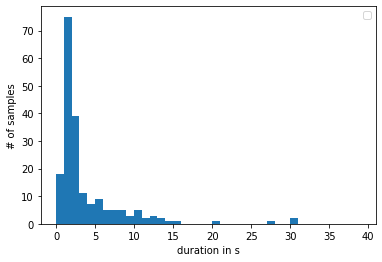

In [5]:
plot_duration_histogram(chunks["right"])

Mean 2.75 +/- 4.16


No handles with labels found to put in legend.


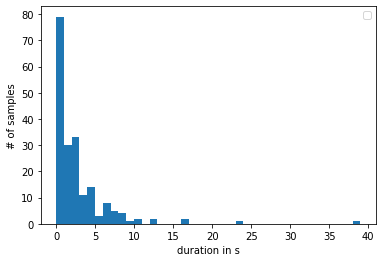

In [6]:
plot_duration_histogram(null_chunks["right"])

In [7]:
# append the action id to the dataframe
# we need to do this to be able to extract time series features later
chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

labels = y.loc[:, "label"].squeeze()

## Classification step 1: OCD activities vs null class samples

### Segmentation

In [8]:
window_size = 50

# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


### Feature extraction for OCD activities vs non-OCD activities

In [9]:
X_null_classification = extract_timeseries_features(null_classification_df)
X_null_classification.to_csv(index=False)
#X_null_classification = pd.read_csv("X_null_classification")

Feature Extraction: 100%|██████████| 30/30 [02:29<00:00,  5.00s/it]


In [10]:
X_null_classification

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,gyroscope z_right__symmetry_looking__r_0.9500000000000001,gyroscope z_right__time_reversal_asymmetry_statistic__lag_1,gyroscope z_right__time_reversal_asymmetry_statistic__lag_2,gyroscope z_right__time_reversal_asymmetry_statistic__lag_3,gyroscope z_right__value_count__value_-1,gyroscope z_right__value_count__value_0,gyroscope z_right__value_count__value_1,gyroscope z_right__variance,gyroscope z_right__variance_larger_than_standard_deviation,gyroscope z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",167.953049,8.957974,-0.059471,-0.189866,0.110603,-1.003411,-1.874286,-2.604457,0.302854,NaN,...,1.0,1.056203e-01,0.170020,0.183855,0.0,0.0,0.0,0.434604,0.0,6.233826
"(1, 0)",218.586671,8.647895,-0.098439,-0.118585,0.184520,-1.572220,-1.724199,-2.061510,0.021921,NaN,...,1.0,-5.486052e-01,-1.234882,-1.942275,0.0,0.0,0.0,1.739353,1.0,1.092511
"(2, 0)",218.015628,8.022149,-0.027011,-0.032235,0.151766,-1.408983,-1.763150,-2.293532,0.096216,NaN,...,1.0,-1.649872e-03,-0.005920,-0.017272,0.0,0.0,0.0,0.145103,0.0,-18.083284
"(3, 0)",275.563692,8.384348,0.035278,0.002904,0.231928,-2.161386,-2.314564,-2.600481,-0.002883,NaN,...,1.0,-3.087183e-03,-0.006130,-0.008546,0.0,0.0,0.0,0.175046,0.0,0.712672
"(4, 0)",213.509314,8.350165,-0.203737,0.007952,0.372836,-1.044852,-1.297057,-1.598812,0.015020,NaN,...,1.0,1.061256e+00,2.057375,2.732315,0.0,0.0,0.0,1.703876,1.0,2.374357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(380, 2)",466.790861,16.136905,-0.080708,-0.090959,0.169142,-0.930710,-1.608860,-2.943829,0.573617,NaN,...,1.0,-3.487797e-03,-0.005950,-0.006590,0.0,0.0,0.0,0.022629,0.0,1.931610
"(382, 0)",711.273782,15.462505,-0.118911,-0.149620,0.256254,-1.622430,-1.847990,-2.612831,-0.047507,NaN,...,1.0,-5.749818e-07,-0.000001,-0.000003,0.0,0.0,0.0,0.000662,0.0,0.567856
"(383, 0)",491.638500,17.164677,-0.008957,0.037739,0.116733,-2.488344,-2.879408,-3.443040,0.172701,NaN,...,1.0,3.782514e-06,0.000056,0.000086,0.0,0.0,0.0,0.003918,0.0,-3.045943


### Feature selection for OCD activities vs non-OCD activities

In [11]:
impute(X_null_classification)
X_null_classification_selected = select_features(X_null_classification, labels_null_classification)


/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:173: RuntimeWarning: The columns ['acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'
 'acceleration x__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"'
 ... 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_97'
 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_98'
 'gyroscope z_right__fft_coefficient__attr_"real"__coeff_99'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


In [12]:
labels_null_classification

(0, 0)      OCD activity
(1, 0)      OCD activity
(2, 0)      OCD activity
(3, 0)      OCD activity
(4, 0)      OCD activity
                ...     
(380, 2)      null class
(382, 0)      null class
(383, 0)      null class
(383, 1)      null class
(384, 0)      null class
Length: 1319, dtype: object

In [13]:
#X_null_classification_selected.loc[:'acceleration x__fft_coefficient__attr_"angle"__coeff_0']

In [14]:
#X_two_handed_selected_null_test

In [15]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [16]:
#labels_null_classification.reset_index(drop=True)


### Train models and score results

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_null_classification)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

finalDf = pd.concat([principalDf, labels_null_classification.reset_index(drop=True)], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'principal component 3', 'target']

In [18]:
finalDf

,principal component 1,principal component 2,principal component 3,target
0,-11.278417,-5.066299,7.213989,OCD activity
1,-9.546519,-7.141239,6.622173,OCD activity
2,-10.946672,-3.726413,3.709285,OCD activity
3,-10.801452,-5.783212,7.136635,OCD activity
4,-10.346633,-7.043149,5.888973,OCD activity
...,...,...,...,...
1314,-14.294978,-0.199217,9.196609,null class
1315,-15.966027,3.668233,6.660708,null class
1316,-12.200368,-0.410394,7.137062,null class
1317,-16.176862,0.005259,9.770544,null class


In [19]:
%matplotlib notebook
from matplotlib import interactive
interactive(True)

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

targets = ['OCD activity', 'null class']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color)
ax.legend(targets)
ax.grid()

<IPython.core.display.Javascript object>

In [41]:
print("Two handed classification")
classify_all(finalDf.drop("target", axis=1), finalDf["target"])

Two handed classification
Logistic Regression: 0.63 +/- 0.09
LDA: 0.63 +/- 0.09
LinearSVC: 0.62 +/- 0.06
CART: 0.56 +/- 0.07
Random Forest: 0.60 +/- 0.07
XGBoost binary: 0.57 +/- 0.08
XGBoost mult: nan +/- nan
NB: 0.60 +/- 0.13
SVC: 0.62 +/- 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [33]:
finalDf["target"]

0       OCD activity
1       OCD activity
2       OCD activity
3       OCD activity
4       OCD activity
            ...     
1314      null class
1315      null class
1316      null class
1317      null class
1318      null class
Name: target, Length: 1319, dtype: object

In [ ]:
# TODO: plot feature importance (which feature has the most impact on the results)

import matplotlib.pyplot as plt


def swarm_plot_top_features(data):
    sns.set(style="whitegrid", palette="muted")
    data = pd.melt(data, id_vars=["index", "class"], var_name="features")
    print(data.head())
    plt.figure(figsize=(25,10))
    sns.swarmplot(x="features", y="value", hue="class", data=data)

#sns.pairplot(pd.DataFrame(X_null_classification[:, :10]))

In [22]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

(0, 0)      OCD activity
(1, 0)      OCD activity
(2, 0)      OCD activity
(3, 0)      OCD activity
(4, 0)      OCD activity
                ...     
(380, 2)      null class
(382, 0)      null class
(383, 0)      null class
(383, 1)      null class
(384, 0)      null class
Length: 1319, dtype: object

In [23]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [24]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_two_handed_selected_null_test.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())
#X_y.reset_index()[:-10]
#X_y.head()

NameError: name 'X_two_handed_selected_null_test' is not defined

In [ ]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


### Feature extraction for 2 handed classifier of activities against each other

In [ ]:
pd.concat(chunks_two_handed).reset_index(drop=True)

In [ ]:
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

In [ ]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

### Feature selection for 2 handed classifier of activities against each other

In [ ]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

In [ ]:
labels

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

NameError: name 'finalDf' is not defined

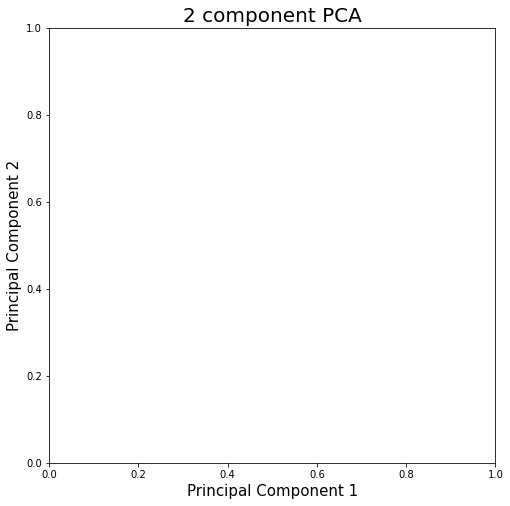

In [1]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['OCD activity', 'null class']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [40]:
print("Two handed classification")
classify_all(X_null_classification, labels_null_classification)

Two handed classification
Logistic Regression: 0.56 +/- 0.05
LDA: 0.52 +/- 0.06
LinearSVC: 0.56 +/- 0.04
CART: 0.55 +/- 0.08
Random Forest: 0.58 +/- 0.10
XGBoost binary: 0.59 +/- 0.08
XGBoost mult: nan +/- nan
NB: 0.51 +/- 0.10
SVC: 0.61 +/- 0.10


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [41]:
# TODO: plot feature importance (which feature has the most impact on the results)

import matplotlib.pyplot as plt


def swarm_plot_top_features(data):
    sns.set(style="whitegrid", palette="muted")
    data = pd.melt(data, id_vars=["index", "class"], var_name="features")
    print(data.head())
    plt.figure(figsize=(25,10))
    sns.swarmplot(x="features", y="value", hue="class", data=data)

#sns.pairplot(pd.DataFrame(X_null_classification[:, :10]))

In [42]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

(0, 0)      OCD activity
(1, 0)      OCD activity
(2, 0)      OCD activity
(3, 0)      OCD activity
(4, 0)      OCD activity
                ...     
(380, 2)      null class
(382, 0)      null class
(383, 0)      null class
(383, 1)      null class
(384, 0)      null class
Length: 1319, dtype: object

In [43]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [44]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_two_handed_selected_null_test.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())
#X_y.reset_index()[:-10]
#X_y.head()

NameError: name 'X_two_handed_selected_null_test' is not defined

In [ ]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


### Feature extraction for 2 handed classifier of activities against each other

In [ ]:
pd.concat(chunks_two_handed).reset_index(drop=True)

In [ ]:
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

In [ ]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

### Feature selection for 2 handed classifier of activities against each other

In [ ]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

In [ ]:
labels

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

Train models and score results

In [ ]:
print("Two handed classification")
classify_all(X, labels, label_ids)